In [8]:
import pandas as pd
question_per_library = pd.read_csv(
    'C:/stackoverflow.zip', parse_dates= True, index_col='creation_date'
).loc[:,'pandas':'bokeh'].resample('1M').sum().cumsum().reindex(
pd.date_range('2008-08','2021-10',freq='M')).fillna(0)
question_per_library.tail()

,pandas,matplotlib,numpy,seaborn,geopandas,geoviews,altair,yellowbrick,vega,holoviews,hvplot,bokeh
2021-05-31,200734.0,57853.0,89812.0,6855.0,1456.0,57.0,716.0,46.0,532.0,513.0,84.0,4270.0
2021-06-30,205065.0,58602.0,91026.0,7021.0,1522.0,57.0,760.0,48.0,557.0,521.0,88.0,4308.0
2021-07-31,209235.0,59428.0,92254.0,7174.0,1579.0,62.0,781.0,50.0,572.0,528.0,89.0,4341.0
2021-08-31,213410.0,60250.0,93349.0,7344.0,1631.0,62.0,797.0,52.0,589.0,541.0,92.0,4372.0
2021-09-30,214919.0,60554.0,93797.0,7414.0,1652.0,63.0,804.0,54.0,598.0,542.0,92.0,4386.0


In [9]:
from matplotlib.animation import FuncAnimation

In [10]:
import matplotlib.pyplot as plt
from matplotlib import ticker

def bar_plot(data):
    fig, ax= plt.subplots(figsize=(8,6))
    sort_order = data.last('1M').squeeze().sort_values().index
    bars= [
        bar.set_label(label) for label, bar in
        zip(sort_order, ax.barh(sort_order, [0] * data.shape[1]))
    ]
    
    ax.set_xlabel('total questions',fontweight='bold')
    ax.set_xlim(0,250_000)
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    for spine in ['top','right']:
        ax.spines[spine].set_visible(False)
    fig.tight_layout()
    return fig, ax

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x5412c50>)

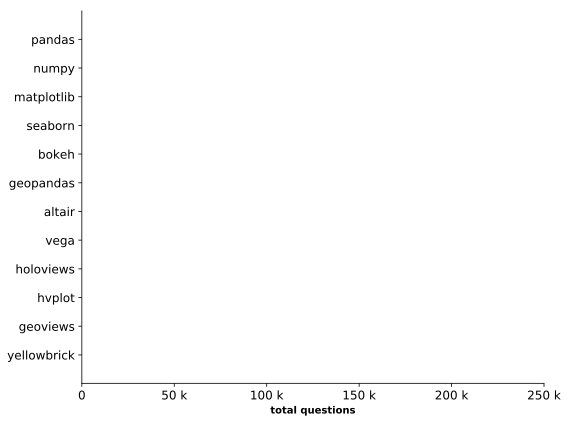

In [11]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
bar_plot(question_per_library)


In [12]:
def generate_plot_text(ax):
    annotations = [
        ax.annotate(
            '',xy=(0, bar.get_y() + bar.get_height()/2),
            ha='left', va='center'
        ) for bar in ax.patches
    ]
    
    time_text= ax.text(
        0.9, 0.1,'', transform=ax.transAxes,
        fontsize= 15, ha='center', va='center'
    )
    return annotations, time_text

In [13]:
def update(frame, *, ax, df, annotations, time_text):
    data = df.loc[frame,:]
    
    for rect, text in zip(ax.patches, annotations):
        col = rect.get_label()
        if data[col]:
            rect.set_width(data[col])
            text.set_x(data[col])
            text.set_text(f' {data[col]:,.0f}')
            
    time_text.set_text(frame.strftime('%b\n%Y'))
        

In [14]:
from functools import partial

def bar_plot_init(question_per_library):
    fig, ax=bar_plot(question_per_library)
    annotations, time_text = generate_plot_text(ax)
    
    bar_plot_update= partial(
    update, ax=ax, df= question_per_library,
    annotations= annotations, time_text=time_text)
    return fig, bar_plot_update

In [15]:
fig, update_func=bar_plot_init(question_per_library)

ani = FuncAnimation(
    fig, update_func, frames=question_per_library.index, repeat= False
)
ani.save('C:/stackoverflow_questions.mp4',
         writer='ffmpeg',fps=10,bitrate=100,dpi=300)
plt.close()

In [17]:
from IPython import display

display.Video(
    'C:/stackoverflow_questions.mp4', width=600, height=400,
    embed=True, 
    
)

In [29]:
subway= pd.read_csv('C:/NYC_subway_daily.csv', parse_dates=['Datetime'],
                   index_col=['Borough','Datetime'])
subway_daily= subway.unstack(0)
subway_daily.head()

Entries                                    Exits            \
Borough            Bk        Bx          M         Q        Bk        Bx   
Datetime                                                                   
2017-02-04   617650.0  247539.0  1390496.0  408736.0  417449.0  148237.0   
2017-02-05   542667.0  199078.0  1232537.0  339716.0  405607.0  139856.0   
2017-02-06  1184916.0  472846.0  2774016.0  787206.0  761166.0  267991.0   
2017-02-07  1192638.0  470573.0  2892462.0  790557.0  763653.0  270007.0   
2017-02-08  1243658.0  497412.0  2998897.0  825679.0  788356.0  275695.0   

                                 
Borough             M         Q  
Datetime                         
2017-02-04  1225689.0  279699.0  
2017-02-05  1033610.0  268626.0  
2017-02-06  2240027.0  537780.0  
2017-02-07  2325024.0  544828.0  
2017-02-08  2389534.0  559639.0

In [30]:
manhattan_entries= subway_daily['Entries']['M']

In [31]:
import numpy as np
count_per_bin, bin_ranges = np.histogram(manhattan_entries,bins=30)

In [32]:
def subway_histogram(data, bins, date_range):
    _,bin_ranges = np.histogram(data, bins=bins)
    weekday_mask= data.index.weekday <5
    configs = [
        {'label': 'weekend', 'mask': ~weekday_mask, 'ymax':60},
        {'label': 'weekend', 'mask': weekday_mask, 'ymax':120},
    ]
    fig, axes = plt.subplots(1,2, figsize=(8,4), sharex= True)
    for ax, config in zip(axes, configs):
        _,_,config['hist']= ax.hist(
            data[config['mask']].loc[date_range],bin_ranges, ec='black'
        )
        ax.xaxis.set_major_formatter(ticker.EngFormatter())
        ax.set(
        xlim=(0,None), ylim=(0, config['ymax']),
        xlabel=f'{config["label"]} Entries'
        )
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
    axes[0].set_ylabel('Frequency')
    fig.suptitle('histogram')
    fig.tight_layout()
    return fig, axes, bin_ranges, configs

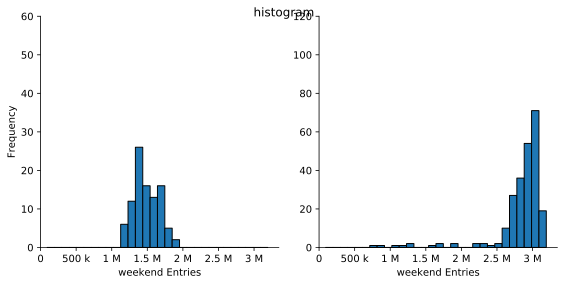

In [33]:
_= subway_histogram(manhattan_entries, bins= 30, date_range='2017')

In [34]:
def add_time_text(ax):
    time_text = ax.text(
    0.15,0.9,'',transform=ax.transAxes,
    fontsize=15, ha= 'center',va='center')
    return time_text

In [35]:
def update(frame, *, data, configs, time_text, bin_ranges):
    artists=[]
    time = frame.strftime('%b\n%Y')
    if time != time_text.get_text():
        time_text.set_text(time)
        artists.append(time_text)
        
    for config in configs:
        time_frame_mask = \
        (data.index > frame - pd.Timedelta(days=365))&(data.index<=frame)
        counts,_=np.histogram(
            data[time_frame_mask & config['mask']],
            bin_ranges
        )
        for count, rect in zip(counts, config['hist']):
            if count != rect.get_height():
                rect.set_height(count)
                artists.append(rect)
    return artists

In [36]:
def histogram_init(data, bins, initial_date_range):
    fig,axes, bin_ranges, configs= subway_histogram(data, bins,initial_date_range)
    update_func = partial(
        update, data=data, configs=configs,
        time_text= add_time_text(axes[0]),
        bin_ranges=bin_ranges
    )
    return fig, update_func

In [37]:
fig, update_func = histogram_init(
    manhattan_entries, bins=30, initial_date_range=slice('2017', '2019-07')
)

ani = FuncAnimation(
    fig, update_func, frames=manhattan_entries['2019-08':'2021'].index,
    repeat=False, blit=True
)
ani.save('C:/subway_entries_subplots.mp4',
writer='ffmpeg', fps=30, bitrate=500, dpi=300

)

plt.close()

In [38]:
def histogram_init(data, bins, initial_date_range):
    fig, axes, bin_ranges, configs = subway_histogram(data, bins, initial_date_range)
    
    update_func = partial(
        update, data=data, configs=configs,
        time_text=add_time_text(axes[0]),
        bin_ranges=bin_ranges
    )
    return fig, update_func

In [39]:
fig, update_func = histogram_init(
    manhattan_entries, bins=30, initial_date_range=slice('2017', '2019-07')
)

ani = FuncAnimation(
    fig, update_func, frames=manhattan_entries['2019-08':'2021']. index,
    repeat=False, blit=True
)
ani.save(
    'C:/subway_entries_subplots.mp4',
    writer='ffmpeg', fps=30, bitrate=500, dpi=300
)
plt.close()

In [40]:
from IPython import display

display.Video(
    'C:/subway_entries_subplots.mp4', width=600, height=400,
    embed=True, 
)

In [41]:
import geopandas as gpd
import pandas as pd

In [42]:
df = gpd.read_file('C:/earthquakes.geojson')

In [43]:
earthquakes = gpd.read_file('C:/earthquakes.geojson').assign(
time=lambda x: pd.to_datetime(x.time, unit ='ms'),
month = lambda x: x.time.dt.month
)[['geometry','mag','time','month']].dropna()
earthquakes.shape
earthquakes.head()

,geometry,mag,time,month
0,POINT Z (-67.12750 19.21750 12.00000),2.75,2020-01-01 00:01:56.590,1
1,POINT Z (-67.09010 19.07660 6.00000),2.55,2020-01-01 00:03:38.210,1
2,POINT Z (-66.85410 17.87050 6.00000),1.81,2020-01-01 00:05:09.440,1
3,POINT Z (-66.86360 17.89930 8.00000),1.84,2020-01-01 00:05:36.930,1
4,POINT Z (-66.86850 17.90660 8.00000),1.64,2020-01-01 00:09:20.060,1
